In [2]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [2]:
cd "/drive/My Drive/PGM_Project/"

/drive/My Drive/PGM_Project


In [4]:
! pip install phonetics

  Created wheel for phonetics: filename=phonetics-1.0.5-py2.py3-none-any.whl size=8712 sha256=908d6447ffc785759ac51025bb7eb9b914f92ccc6319c730c3706d3642d33790
  Stored in directory: /root/.cache/pip/wheels/ad/ca/b1/e41e662f86b95d185748da378fdc995c1520b0d5628c46a0b7
Successfully built phonetics


In [0]:
import numpy as np
import json
import pandas as pd
import os
import pickle
import ast
import phonetics
from tqdm import tqdm
import string
import random
import matplotlib.pyplot as plt

# **CONDITIONAL RANDOM FIELD FOR SCENE TEXT RECOGNITION**

## **Preprocessing Block**

In [0]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1]))
    
def preprocess_candidates():
  """
  Prunes and Select the most appropriate candidate predictions based on the confidence values
  
  Returns
  -------
  list
  Pruned candidates, each with an upper limit of "maxlen"
  """
  cand = []
  maxlen = 3
  for c in range(len(candidates_withoutpuncdig)):
    copy = candidates_withoutpuncdig[c].copy()
    num_wordcand = len(candidates_withoutpuncdig[c])
    if num_wordcand > maxlen:
      sortedcand = Sort_Tuple(copy)
      cand.append(sortedcand[0:maxlen])
    else:
      cand.append(copy)
  return cand

## **Statistics Block**

In [0]:
def get_numcand_perwordimg():
  """
  Obtain the number of candidates words per word-crop image

  Returns
  -------
  dict
  Word image id, with corresponding number of candidate predictions
  """
  numcand = {}
  assert len(candidates_withoutpuncdig) == num_words
  for i in range(num_words):
    numcand[i] = len(candidates_withoutpuncdig[i])
  return numcand

In [0]:
def get_numcomb_perimg():
  """
  Obtain the number of candidate combinations to be potential sequences

  Returns
  -------
  list
  Contains the number of potential sequences for corresponding image i, at index i
  """
  numcomb = []
  for im in range(start, num_imgs, skip):
    index = im + 1
    if imgfreq[index] == 0:
      numcomb.append(0)
      continue

    tup = imgdict[index]
    st = tup[0]
    end = tup[1]
    prod = 1
    for k in range(st, end+1):
      prod *= numcand[k]
    numcomb.append(prod)
  return numcomb

In [0]:
def get_truewords():
  """
  Get the ground truth words

  Returns
  -------
  list
  Contains the ground truth words
  """
  linestoremove = []
  truewords = []
  for line in flines:
    arr = line.split("\t")
    word = arr[1].rstrip()
    truewords.append(word)
  return truewords

In [0]:
def create_imgfreq():
  """
  Obtain number of words in a signboard image

  Returns
  -------
  dict
  Image number with corresponsing number of words
  """
  imgfreq = {}
  for line in flines:
    arr = line.split("/")
    label = arr[1].split("_")
    imgnum = int(label[0])
    if imgnum not in imgfreq:
      imgfreq[imgnum] = 1
    else:
      imgfreq[imgnum] += 1
  return imgfreq

In [0]:
def create_imgdict(imgfreq):
  """
  Obtain the start and end index of the predictions for an image

  Returns
  -------
  dict
  Image number with corresponding number of words, start index and end index of predictions
  """
  imgdict = {}
  
  for i in range(start, num_imgs, skip):
    ind = i + 1
    if ind == skip:
      imgdict[ind] = (0, imgfreq[ind] - 1, imgfreq[ind])
    else:
      tup = imgdict[ind - skip]
      imgdict[ind] = (tup[1] + 1, tup[1] + 1 + imgfreq[ind] - 1, imgfreq[ind])
  return imgdict

## **Algorithm Block**

In [0]:
def find_comb(arr):
  """
  Find all combinations of candidate predictions

  Returns
  -------
  list
  possible sequences for an image 
  """
  n = len(arr)
  toret = []
  indices = [0 for i in range(n)] 

  while(1):
    ar = []
    for i in range(n):
        ar.append(arr[i][indices[i]])
    toret.append(ar)

    next = n - 1
    while (next >= 0 and (indices[next] + 1 >= len(arr[next]))): 
        next-=1

    if (next < 0):
        return toret

    indices[next] += 1

    for i in range(next + 1, n):
        indices[i] = 0

In [0]:
def find_energy_onlyDL(c):
  """
  Only DL model

  Returns
  -------
  Energy for a sequence by considering only bottom up unigrams terms
  """
  unary_energy = sum(n for _, n in c)
  total_energy = lambdaunigram * unary_energy
  return total_energy

In [0]:
def find_energy_linear(c):
  """
  Linear CRF

  Returns
  -------
  Energy for a sequence by considering network with only adjacent node edges
  """
  unary_energy = sum(n for _, n in c)
  # bigrams = Combination(c)
  bigram_energy = 0
  for a in range(len(c)):
    tup1 = c[a]
    ind1 = tup1[0]
    if a != len(c) - 1:
      tup2 = c[a + 1]
      ind2 = tup2[0]
      bigramtuple = (ind1, ind2)
      try:
        bigram_energy += bigramprobs[bigramtuple]
      except:
        bigram_energy += outofvocab

    if a != 0:
      tup2 = c[a - 1]
      ind2 = tup2[0]
      bigramtuple = (ind1, ind2)
      try:
        bigram_energy += bigramprobs[bigramtuple]
      except:
        bigram_energy += outofvocab

  total_energy = lambdaunigram * unary_energy + lambdabigram * bigram_energy
  return total_energy

In [0]:
def find_energy_nonlinear(c):
  """
  Nonlinear CRF

  Returns
  -------
  Energy for a sequence by considering fully connected network
  """
  unary_energy = sum(n for _, n in c)
  bigram_energy = 0
  cind1 = 0
  for a in c:
    cind2 = 0
    for b in c:
      if cind1 >= cind2:
        cind2 += 1
        continue
      ind1 = a[0]
      ind2 = b[0]
      bigramtuple = (ind1, ind2)
      try:
        bigram_energy += bigramprobs[bigramtuple]
      
      except:
        bigram_energy += outofvocab

      cind2 += 1
    cind1 += 1
  total_energy = lambdaunigram * unary_energy + lambdabigram * bigram_energy
  return total_energy

In [0]:
def find_energy_nonlinear_positionalweighting(c):
  """
  Nonlinear CRF

  Returns
  -------
  Energy for a sequence by considering fully connected network with positional weighting
  """
  unary_energy = sum(n for _, n in c)
  bigram_energy = 0
  cind1 = 0
  for a in c:
    cind2 = 0
    for b in c:
      if cind1 >= cind2:
        cind2 += 1
        continue
      ind1 = a[0]
      ind2 = b[0]
      bigramtuple = (ind1, ind2)
      try:
        bigram_energy += 1/(cind2 - cind1) * bigramprobs[bigramtuple]
      
      except:
        bigram_energy += 1/(cind2 - cind1) * outofvocab

      cind2 += 1
    cind1 += 1
  total_energy = lambdaunigram * unary_energy + lambdabigram * bigram_energy
  return total_energy

In [0]:
def get_sequence(s):
  """
  Covert list of tuples of the form (word, unigram energy) to list of words

  Returns
  -------
  list
  converted list of words
  """
  seq = []
  for tup in s:
    seq.append(tup[0])
  return seq

In [0]:
def find_minenergysequence(comb, choice):
  """
  Finds sequence with minimum energy

  Returns
  -------
  list
  sequence of candidate words which yielded the lowest energy
  """
  cnt = 0
  for c in comb:
    if choice == 0:
      energy = find_energy_onlyDL(c)
    elif choice == 1:
      energy = find_energy_linear(c)
    elif choice == 2:
      energy = find_energy_nonlinear(c)
    elif choice == 3:
      energy = find_energy_nonlinear_positionalweighting(c)
    if cnt == 0:
      minenergy = energy
      sequence = c
      cnt += 1
    elif energy < minenergy:
      minenergy = energy
      sequence = c

  ret = get_sequence(sequence)
  return ret

In [0]:
def find_sequence(img_num, choice):
  """
  Get all combinations of candidate words and return the sequence with minimum energy

  Returns
  -------
  list
  sequence of candidate words which yielded the lowest energy
  """
  tup = imgdict[img_num]
  start = tup[0]
  end = tup[1]
  findcomb = candidates_withoutpuncdig[start:end+1]

  combinations = find_comb(findcomb)

  assert len(combinations) <= upperlim

  # if len(combinations) < 20:
  #   print("Combinations")
  #   for i in combinations:
  #     print(i)
  #   print("END")
  sequence = find_minenergysequence(combinations, choice)
  return sequence

In [0]:
def get_true_sequence(img_num):
  """
  Obtain the true word sequence for an image

  Returns
  -------
  list
  true word sequence for image img_num obtained from ground truth
  """
  tup = imgdict[img_num]
  return truewords[tup[0]:tup[1]+1]

In [0]:
# https://www.geeksforgeeks.org/edit-distance-dp-5/

def edit_dist(str1, str2):
  """
  Calculates edit distance between 2 words

  Returns
  -------
  Edit distance value
  """
  str1 = str1.lower()
  str2 = str2.lower()
  m = len(str1)
  n = len(str2)
  dp = [[0 for x in range(n + 1)] for x in range(m + 1)] 

  for i in range(m + 1): 
      for j in range(n + 1): 

          if i == 0: 
              dp[i][j] = j    

          elif j == 0: 
              dp[i][j] = i     

          elif str1[i-1] == str2[j-1]: 
              dp[i][j] = dp[i-1][j-1] 

          else: 
              dp[i][j] = 1 + min(dp[i][j-1],       # Insert 
                                  dp[i-1][j],      # Remove 
                                  dp[i-1][j-1])    # Replace 

  return dp[m][n]

In [0]:
def pun(one, two):
  """
  Obtain edit distance between 2 sequences 

  Returns
  -------
  Overall edit distance calculated by summing over individual word edit distances
  """
  assert len(one) == len(two)
  length = len(one)
  punish = 0
  for i in range(length):
    dist = edit_dist(one[i], two[i])
    punish += dist
  return punish

In [0]:
def normalize_text(text):
  """
  Transforms the text

  Returns
  -------
  string
  Transformed text after removing punctuation marks and converting to lowercase
  """
  text = ''.join(filter(lambda x: x in (string.digits + string.ascii_letters), text))
  return text.lower()

In [0]:
def acc(one, two):
  """
  Obtain number of matching words in predicted and actual sequence

  Returns
  -------
  tuple
  number of matching words and number of total words
  """
  assert len(one) == len(two)
  length = len(one)
  matches = 0
  for i in range(length):
    o = normalize_text(one[i])
    t = normalize_text(two[i])
    if o == t:
      matches += 1
  percent_match = matches/length
  return matches, length

In [0]:
# https://stackabuse.com/phonetic-similarity-of-words-a-vectorized-approach-in-python/
# https://github.com/Zack--/phonetics
# https://pypi.org/project/phonetics/

def levenshtein(seq1, seq2):
  """
  Utility fn for calculating phonetic distance
  """
  size_x = len(seq1) + 1
  size_y = len(seq2) + 1
  matrix = np.zeros ((size_x, size_y))
  for x in range(size_x):
      matrix [x, 0] = x
  for y in range(size_y):
      matrix [0, y] = y

  for x in range(1, size_x):
      for y in range(1, size_y):
          if seq1[x-1] == seq2[y-1]:
              matrix [x,y] = min(matrix[x-1, y] + 1, matrix[x-1, y-1], matrix[x, y-1] + 1)
          else:
              matrix [x,y] = min(matrix[x-1,y] + 1, matrix[x-1,y-1] + 1, matrix[x,y-1] + 1)
  return (matrix[size_x - 1, size_y - 1])


def phon(one, two):
  """
  Get the phonetic distance between 2 sequences

  Returns
  -------
  float
  Value indicating the phonetic dissimilarity between the inputs
  """
  assert len(one) == len(two)
  length = len(one)
  total = 0.0

  indicator = 0

  for k in range(length):
    word1 = one[k].lower()
    word2 = two[k].lower()

    weight = {"soundex": 0.3, "metaphone": 0.5, "nysiis": 0.2}

    try:

      code1 = phonetics.soundex(word1)
      code2 = phonetics.soundex(word2)
      lev = levenshtein (code1, code2)
      currentWeight = weight["soundex"]
      subtotal = lev * currentWeight
      total += subtotal

      code1 = phonetics.nysiis(word1)
      code2 = phonetics.nysiis(word2)
      lev = levenshtein (code1, code2)
      currentWeight = weight["nysiis"]
      subtotal = lev * currentWeight
      total += subtotal

      code1 = phonetics.metaphone(word1)
      code2 = phonetics.metaphone(word2)
      lev = levenshtein (code1, code2)
      currentWeight = weight["metaphone"]
      subtotal = lev * currentWeight
      total += subtotal
    
    except:
      indicator += 1
      continue

  if indicator == length:
    return None

  return total

In [0]:
def get_perf(img_num, true_sequence, choice):
  """
  Get the performance on the a test image

  Returns
  -------
  tuple
  Edit distance, number of word matches and phonetic distance
  """
  pred_sequence = find_sequence(img_num, choice)
  assert len(pred_sequence) == imgdict[img_num][2]
  # print(true_sequence)
  # print(pred_sequence)
  editdist = pun(pred_sequence, true_sequence)
  wordmatch, tot = acc(pred_sequence, true_sequence)
  phoneticdiff = phon(pred_sequence, true_sequence)
  return editdist, wordmatch, tot, phoneticdiff

In [0]:
train = True

In [36]:
if train == True:
  with open('/drive/My Drive/PGM_Project/data/bigram.json') as f:
    bigramprobs = json.load(f)
    bigramprobs = bigramprobs.upper()
    curly = bigramprobs.index('{')
    bigramprobs = bigramprobs[curly:-1]
    bigramprobs = ast.literal_eval(bigramprobs)
  candidates_temp = pickle.load(open("/drive/My Drive/PGM_Project/data/candidates.pkl", 'rb'))
  print(len(candidates_temp))
  f = open("/drive/My Drive/PGM_Project/data/test_gt_ds.txt", 'r')
  flines = f.readlines()
  f.close()
  print(len(flines))

  assert len(candidates_temp) == len(flines)

  # candidates_withoutpuncdig = candidates_temp

  candidates_withoutpuncdig = []
  fnew = open("/drive/My Drive/PGM_Project/data/test_gt_ds_withoutpuncdig.txt", 'w')

  for line in range(len(flines)):
    arr = flines[line].split("\t")
    word = arr[1].rstrip()
    if word in string.punctuation or word.isdigit():
      continue
    candidates_withoutpuncdig.append(candidates_temp[line])
    fnew.write(flines[line])
  fnew.close()

  candidates_withoutpuncdig = preprocess_candidates()

  f = open("/drive/My Drive/PGM_Project/data/test_gt_ds_withoutpuncdig.txt", 'r')
  flines = f.readlines()

  print(len(candidates_withoutpuncdig), len(flines))
  assert len(candidates_withoutpuncdig) == len(flines)

  start = 0
  skip = 1

else:
  with open('/drive/My Drive/PGM_Project/data/test/bigram_allexcepttest.json') as f:
    bigramprobs = json.load(f)
    bigramprobs = bigramprobs.upper()
    curly = bigramprobs.index('{')
    bigramprobs = bigramprobs[curly:-1]
    bigramprobs = ast.literal_eval(bigramprobs)
  candidates_temp = pickle.load(open("/drive/My Drive/PGM_Project/data/test/candidates_ontest.pkl", 'rb'))

  f = open("/drive/My Drive/PGM_Project/data/test/test_gt_ds.txt", 'r')
  flines = f.readlines()
  f.close()

  assert len(candidates_temp) == len(flines)

  # candidates_withoutpuncdig = candidates_temp

  candidates_withoutpuncdig = []
  fnew = open("/drive/My Drive/PGM_Project/data/test/test_gt_ds_withoutpuncdig.txt", 'w')

  for line in range(len(flines)):
    arr = flines[line].split("\t")
    word = arr[1].rstrip()
    if word in string.punctuation or word.isdigit():
      continue
    candidates_withoutpuncdig.append(candidates_temp[line])
    fnew.write(flines[line])
  fnew.close()

  candidates_withoutpuncdig = preprocess_candidates()

  f = open("/drive/My Drive/PGM_Project/data/test/test_gt_ds_withoutpuncdig.txt", 'r')
  flines = f.readlines()


  assert len(candidates_withoutpuncdig) == len(flines)

  start = 4
  skip = 5

3000
3000
2301 2301


In [0]:
num_imgs = 300
num_words = len(flines)
truewords = get_truewords()
imgfreq = create_imgfreq()
imgdict = create_imgdict(imgfreq)
numcand = get_numcand_perwordimg()
numcomb = get_numcomb_perimg()
upperlim = 100000

## **Only Deep Learning Model**

In [38]:
notcounted = 0
wordmatch = 0
wordtot = 0
continued = 0
lambdaunigram = 1
lambdabigram = 0
avged = 0
avgpd = 0
cnt = 0

for img in range(start, num_imgs, skip):
  
  # print("Image number", img+1)
  # print("Number of candidate combinations =", numcomb[img])

  if imgfreq[img + 1] == 0 or numcomb[int(img/skip)] > upperlim:
    continued += 1
    continue

  true_sequence = get_true_sequence(img + 1)
  ed, wm, tot, pd = get_perf(img + 1, true_sequence, 0)
  wordmatch += wm
  wordtot += tot
  avged += ed
  avgpd += pd
  # print("Edit distance =", ed, "\t", "Words matched =", wm, "/", tot, "\t", "Phonetic distance =", pd)
  cnt += 1
print("Word Match Accuracy =", wordmatch/wordtot*100)
print("Average Edit Distance =", avged/cnt)
print("Average Phonetic Distance =", avgpd/cnt)

Word Match Accuracy = 81.88113098672821
Average Edit Distance = 5.335740072202166
Average Phonetic Distance = 2.692418772563177


In [0]:
lambdaunigram = 2
lambdabigram = 1
outofvocab = 2

## **Linear Conditional Random Field**

In [40]:
notcounted = 0
wordmatch = 0
wordtot = 0
continued = 0
avged = 0
avgpd = 0
cnt = 0

for img in range(start, num_imgs, skip):

  # print("Image number", img+1)
  # print("Number of candidate combinations =", numcomb[img])

  if imgfreq[img + 1] == 0 or numcomb[int(img/skip)] > upperlim:
    continued += 1
    continue

  true_sequence = get_true_sequence(img + 1)
  ed, wm, tot, pd = get_perf(img + 1, true_sequence, 1)
  wordmatch += wm
  wordtot += tot
  avged += ed
  avgpd += pd
  # print("Edit distance =", ed, "\t", "Words matched =", wm, "/", tot, "\t", "Phonetic distance =", pd)
  cnt += 1
print(wordmatch, wordtot)
print("Word Match Accuracy =", wordmatch/wordtot*100)
print("Average Edit Distance =", avged/cnt)
print("Average Phonetic Distance =", avgpd/cnt)

1457 1733
Word Match Accuracy = 84.0738603577611
Average Edit Distance = 5.191335740072202
Average Phonetic Distance = 2.637184115523466


# **Non Linear Fully Connected Conditional Random Field**

In [41]:
notcounted = 0
wordmatch = 0
wordtot = 0
continued = 0
avged = 0
avgpd = 0
cnt = 0

for img in range(start, num_imgs, skip):

  # print("Image number", img+1)
  # print("Number of candidate combinations =", numcomb[img])

  if imgfreq[img + 1] == 0 or numcomb[int(img/skip)] > upperlim:
    continued += 1
    continue

  true_sequence = get_true_sequence(img + 1)
  ed, wm, tot, pd = get_perf(img + 1, true_sequence, 2)
  wordmatch += wm
  wordtot += tot
  avged += ed
  avgpd += pd
  # print("Edit distance =", ed, "\t", "Words matched =", wm, "/", tot, "\t", "Phonetic distance =", pd)
  cnt += 1

print("Word Match Accuracy =", wordmatch/wordtot*100)
print("Average Edit Distance =", avged/cnt)
print("Average Phonetic Distance =", avgpd/cnt)

Word Match Accuracy = 84.70859780727062
Average Edit Distance = 5.144404332129964
Average Phonetic Distance = 2.5953068592057758


# **Non Linear Fully Connected Conditional Random Field with Positional Weighting**

In [42]:
notcounted = 0
wordmatch = 0
wordtot = 0
continued = 0
avged = 0
avgpd = 0
cnt = 0

for img in range(start, num_imgs, skip):

  # print("Image number", img+1)
  # print("Number of candidate combinations =", numcomb[img])

  if imgfreq[img + 1] == 0 or numcomb[int(img/skip)] > upperlim:
    continued += 1
    continue

  true_sequence = get_true_sequence(img + 1)
  ed, wm, tot, pd = get_perf(img + 1, true_sequence, 3)
  wordmatch += wm
  wordtot += tot
  avged += ed
  avgpd += pd
  # print("Edit distance =", ed, "\t", "Words matched =", wm, "/", tot, "\t", "Phonetic distance =", pd)
  cnt += 1

print("Word Match Accuracy =", wordmatch/wordtot*100)
print("Average Edit Distance =", avged/cnt)
print("Average Phonetic Distance =", avgpd/cnt)

Word Match Accuracy = 84.65089440276977
Average Edit Distance = 5.129963898916968
Average Phonetic Distance = 2.5949458483754513


## **Plots**

In [0]:
def bigram_to2darr(bigrams):
  """
  Plots Heatmap of bigrams
  """
  unique = {}
  cnt = 0
  for tupl in bigrams:
    aa = tupl[0]
    bb = tupl[1]
    if aa not in unique:
      unique[aa] = cnt
      cnt += 1
    if bb not in unique:
      unique[bb] = cnt
      cnt +=1
  
  siz = len(unique)
  arr_2d = np.ones((siz, siz), dtype=float)
  for tupl in bigrams:
    indd1 = unique[tupl[0]]
    indd2 = unique[tupl[1]]
    value = bigrams[tupl]
    arr_2d[indd1, indd2] = value
  
  plt.imshow(arr_2d, cmap='jet')

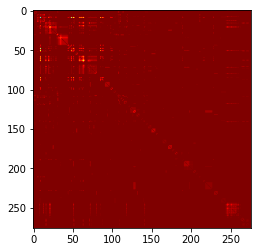

In [55]:
bigram_to2darr(bigramprobs)

Text(0, 0.5, 'Frequency')

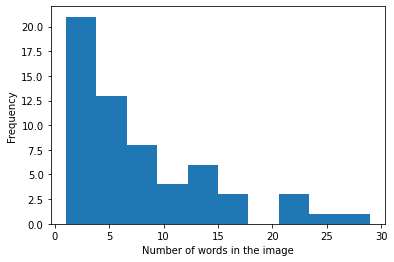

In [56]:
# Plots frequency of number of words in an image
plt.hist(list(imgfreq.values()))
plt.xlabel("Number of words in the image")
plt.ylabel("Frequency")